# 117th Congress Data

This notebook is meant to call, clean, and examine data from the 2020 election, to produce a viable metric correlating PVI and electoral success.

It feeds into a larger project about fairness in redistricting; for instance, if an R+15 district is unattainable for a Democrat to win, then the district can be wholly classified as "safe," and should be bucketed with R+30 district.

The nuance enters in the margins. How safe is an R+6 district for instance? Can we quantify a district moving from R+3 to R+6 as a significant bias against Democrats? By cleaning this dataset, and others like it, we can determine the predictive power of PVI in each district, and use those probabilities later to assess redistricting fairness.

## Retrieve data from Wikipedia

Wikipedia's current Cook PVI page contains a free and current (up to 2020 election results) version of the index, where free downloads from Cook's website are dated, containing 2018 results and 2016 PVI metrics

In [1]:
import requests
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
#import and format url
url = "https://en.wikipedia.org/wiki/Cook_Partisan_Voting_Index"
page = pd.read_html(url)
dat = pd.concat(page,ignore_index=True)

In [3]:
#split data into state and district pvis
wiki_district = dat[0:435]
wiki_state = dat[435:485]

In [4]:
#cut NA columns
wiki_district = wiki_district.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
wiki_state = wiki_state.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

## Clean and Organize State Data

In [5]:
#call in a dictionary of state abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [6]:
state_117 = wiki_state
state_117["ST"] =  state_117["State"]
#abbreviate the ST coulmn
state_117 = state_117.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(state_117["ST"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [7]:
#split out pvi by party and weight
#first eliminate even values
state_117["PVI"] = state_117["PVI"].str.replace("EVEN","R+0")
state_117["pvi_party"] = state_117.PVI.str[0]
state_117['partisan_weight'] = state_117['PVI'].str.split('+').str[1]
#check results
print(state_117.head(n=1))
print(state_117["pvi_party"].unique())

    Housebalance   PVI Party ofgovernor Partyin Senate    State  ST pvi_party  \
435       6R, 1D  R+15       Republican     Republican  Alabama  AL         R   

    partisan_weight  
435              15  
['R' 'D']


In [8]:
#add constants for later aggregation
state_117["year"] = 2020
state_117["congress"] = 117

In [9]:
#create a variable that is negative when the party is democratic
state_117["neg"] = state_117['pvi_party'].str.replace('D','-')
state_117["neg"] = state_117["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
state_117['partisan_weight'] = state_117["neg"] + state_117['partisan_weight']
#ensure values are integers
state_117['partisan_weight'] = state_117['partisan_weight'].astype(int)

In [10]:
state_117["metric"] = ((state_117['partisan_weight'] / 2) + 50) / 100
state_117.head(n=7)

,Housebalance,PVI,Party ofgovernor,Partyin Senate,State,ST,pvi_party,partisan_weight,year,congress,neg,metric
435,"6R, 1D",R+15,Republican,Republican,Alabama,AL,R,15,2020,117,,0.575
436,1R,R+9,Republican,Republican,Alaska,AK,R,9,2020,117,,0.545
437,"5D, 4R",R+3,Republican,Democratic,Arizona,AZ,R,3,2020,117,,0.515
438,4R,R+16,Republican,Republican,Arkansas,AR,R,16,2020,117,,0.580
439,"42D, 11R",D+14,Democratic,Democratic,California,CA,D,-14,2020,117,-,0.430
440,"4D, 3R",D+3,Democratic,Democratic,Colorado,CO,D,-3,2020,117,-,0.485
441,5D,D+7,Democratic,Democratic,Connecticut,CT,D,-7,2020,117,-,0.465


In [11]:
state_117 = state_117[["year","ST","PVI","metric"]]
state_117.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_117.csv",index=False)
#export as the 118th state PVIs as well as the PVI will be unchanged
state_117.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_118.csv",index=False)

## Clean and Organize the District Data

In [12]:
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings('ignore')

In [13]:
#load in and check the data
pvi_117 = wiki_district
print(pvi_117.head(n=1))
print(pvi_117.shape)

    District   PVI Party ofrepresentative
0  Alabama 1  R+16             Republican
(435, 3)


In [14]:
#correct the column name for later use
pvi_117 = pvi_117.rename(columns={"Party ofrepresentative": "Representative"})

In [15]:
#fix at large designation
pvi_117['District'] = pvi_117['District'].str.replace('at-large','AL')
pvi_117.head(n=8)

,District,PVI,Representative
0,Alabama 1,R+16,Republican
1,Alabama 2,R+17,Republican
2,Alabama 3,R+18,Republican
3,Alabama 4,R+34,Republican
4,Alabama 5,R+17,Republican
5,Alabama 6,R+22,Republican
6,Alabama 7,D+19,Democratic
7,Alaska AL,R+9,Republican


In [16]:
#seperate state and district
pvi_117["num"] = pvi_117.District.str[-2:]
pvi_117["state"] = pvi_117.District.str[:-2]
pvi_117["state"] = pvi_117['state'].str.rstrip()
pvi_117["num"] = pvi_117['num'].str.lstrip()
pvi_117["ST"] =  pvi_117["state"]
pvi_117.head(n=1)

,District,PVI,Representative,num,state,ST
0,Alabama 1,R+16,Republican,1,Alabama,Alabama


In [17]:
#abbreviate the ST coulmn
pvi_117 = pvi_117.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(pvi_117["ST"].unique())
print(pvi_117["num"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
['1' '2' '3' '4' '5' '6' '7' 'AL' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53']


In [18]:
#create the district code variable
pvi_117["ST#"] = pvi_117["ST"] + pvi_117["num"]
#create the "party of represenative" variable
pvi_117["seat"] = pvi_117.Representative.str[0]
#make a dummy
pvi_117["is_GOP"] = pvi_117["seat"].replace("R",1)
pvi_117["is_GOP"] = pvi_117["is_GOP"].replace("D",0)
pvi_117["is_GOP"] = pvi_117["is_GOP"].astype(int)
pvi_117.head(n=7)

,District,PVI,Representative,num,state,ST,ST#,seat,is_GOP
0,Alabama 1,R+16,Republican,1,Alabama,AL,AL1,R,1
1,Alabama 2,R+17,Republican,2,Alabama,AL,AL2,R,1
2,Alabama 3,R+18,Republican,3,Alabama,AL,AL3,R,1
3,Alabama 4,R+34,Republican,4,Alabama,AL,AL4,R,1
4,Alabama 5,R+17,Republican,5,Alabama,AL,AL5,R,1
5,Alabama 6,R+22,Republican,6,Alabama,AL,AL6,R,1
6,Alabama 7,D+19,Democratic,7,Alabama,AL,AL7,D,0


In [19]:
#possibly unneccessary
#pull out district lean
pvi_117["lean"] = pvi_117.PVI.str[0]
pvi_117["lean"].unique()

array(['R', 'D', 'E'], dtype=object)

In [20]:
#split out pvi by party and weight
#first eliminate even values
pvi_117["PVI"] = pvi_117["PVI"].str.replace("EVEN","R+0")
pvi_117["pvi_party"] = pvi_117.PVI.str[0]
pvi_117['partisan_weight'] = pvi_117['PVI'].str.split('+').str[1]
#check results
print(pvi_117.head(n=1))
print(pvi_117["pvi_party"].unique())

    District   PVI Representative num    state  ST  ST# seat  is_GOP lean  \
0  Alabama 1  R+16     Republican   1  Alabama  AL  AL1    R       1    R   

  pvi_party partisan_weight  
0         R              16  
['R' 'D']


In [21]:
#create a variable that is negative when the party is democratic
pvi_117["neg"] = pvi_117['pvi_party'].str.replace('D','-')
pvi_117["neg"] = pvi_117["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
pvi_117['partisan_weight'] = pvi_117["neg"] + pvi_117['partisan_weight']
#ensure values are integers
pvi_117['partisan_weight'] = pvi_117['partisan_weight'].astype(int)

In [22]:
pvi_117["metric"] = ((pvi_117['partisan_weight'] / 2) + 50) / 100
pvi_117.head(n=7)

,District,PVI,Representative,num,state,ST,ST#,seat,is_GOP,lean,pvi_party,partisan_weight,neg,metric
0,Alabama 1,R+16,Republican,1,Alabama,AL,AL1,R,1,R,R,16,,0.580
1,Alabama 2,R+17,Republican,2,Alabama,AL,AL2,R,1,R,R,17,,0.585
2,Alabama 3,R+18,Republican,3,Alabama,AL,AL3,R,1,R,R,18,,0.590
3,Alabama 4,R+34,Republican,4,Alabama,AL,AL4,R,1,R,R,34,,0.670
4,Alabama 5,R+17,Republican,5,Alabama,AL,AL5,R,1,R,R,17,,0.585
5,Alabama 6,R+22,Republican,6,Alabama,AL,AL6,R,1,R,R,22,,0.610
6,Alabama 7,D+19,Democratic,7,Alabama,AL,AL7,D,0,D,D,-19,-,0.405


In [23]:
#add constants for later aggregation
pvi_117["year"] = 2020
pvi_117["congress"] = 117

## Export clean versions of the data

In [24]:
#create a dataset solely to correlate pvi with the holder of the seat
pure_117 = pvi_117[["year","metric","is_GOP"]]
pure_117.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/pure_datasets/pure_117.csv",index=False)
#create a more detailed dataset for greater uses
data_117 = pvi_117[["year","congress","ST","ST#","seat","is_GOP","PVI","metric"]]
data_117.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_117.csv",index=False)

In [25]:
data_117.head(8)

,year,congress,ST,ST#,seat,is_GOP,PVI,metric
0,2020,117,AL,AL1,R,1,R+16,0.580
1,2020,117,AL,AL2,R,1,R+17,0.585
2,2020,117,AL,AL3,R,1,R+18,0.590
3,2020,117,AL,AL4,R,1,R+34,0.670
4,2020,117,AL,AL5,R,1,R+17,0.585
5,2020,117,AL,AL6,R,1,R+22,0.610
6,2020,117,AL,AL7,D,0,D+19,0.405
7,2020,117,AK,AKAL,R,1,R+9,0.545


## Conduct preliminary examinations of the data

Because this data is useless in aggregate (2020 alone is not a good basis for prediction, given the lack of accounting for major waves), we will run basic examinations in this notebook

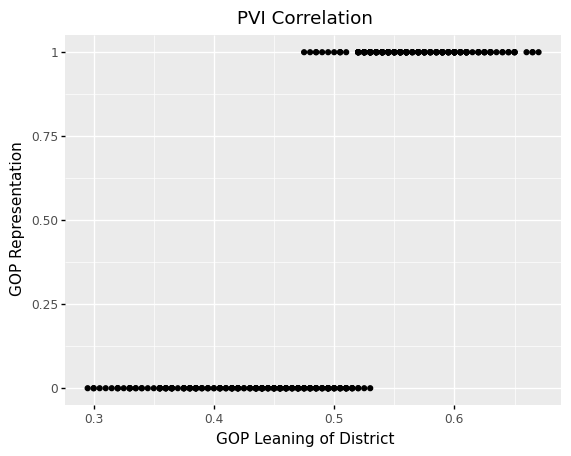

<ggplot: (8784893672156)>

In [26]:
# Create a super simple scatterplot to examine the relationship between PVI and congressional district
(p9.ggplot(data=pure_117, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y='GOP Representation',color="",title="PVI Correlation"))

From the 117th Congress, we can see that generally PVI is a perfect predictor of race outcome, except within the range of approximatley D+5 to R+5. 

In [27]:
#group by metric and average GOP seats
bm_117 = pure_117.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_117 = bm_117.reset_index()

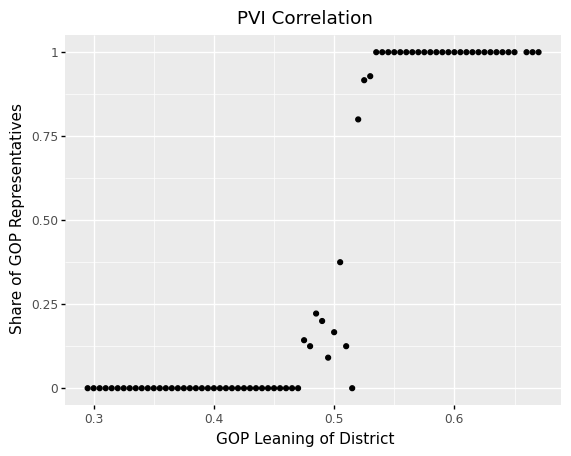

<ggplot: (8784893692513)>

In [28]:
#Plot averages
(p9.ggplot(data=bm_117, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

Herein we see the error in a single cycle dataset- this would imply that a certain republican PVI still has a 100% change of being democratically represented. At a glance, this appears to be R+3, where all four districts with that value, in Iowa, New York, New Jersey, and Virginia, sent Democrats to Congress, and no R+3 district sent a Republican.

In [29]:
#now lets limit the data to only the R+10 to D+10 range, calling it Limited Domain
ld_117 = bm_117[bm_117["metric"] <= .55]
ld_117 = ld_117[ld_117["metric"] >= .45]

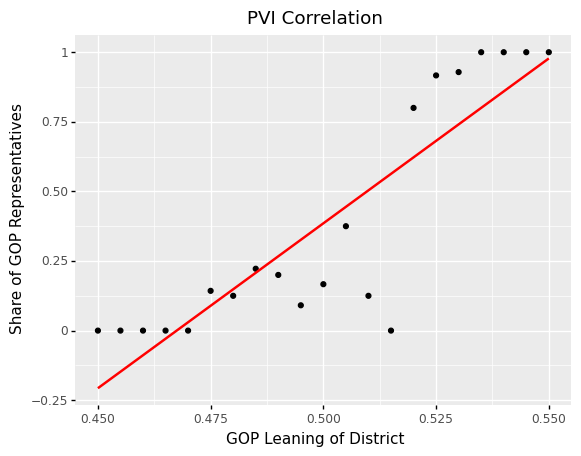

<ggplot: (8784894029948)>

In [30]:
#Plot averages
(p9.ggplot(data=ld_117, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + geom_smooth(method = "lm", color = "red", se = False)
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))